##### Data to Use

***

[Contract Awards in Investment Project Financing](https://dev.socrata.com/foundry/finances.worldbank.org/kdui-wcs3)

> It contains the countries that which the project was awarded a fund, the sector in which the project will be performed, and the amount in USD, together with awarding date.

- API: https://finances.worldbank.org/resource/kdui-wcs3.json

***

[Contract Awards in Investment Project Financing (since FY 2001 - FY 2016)](https://dev.socrata.com/foundry/finances.worldbank.org/4bhp-2q7b)

> It contains the contract awards which precedes the above dataset, containing data about preceding years.

- API: https://finances.worldbank.org/resource/4bhp-2q7b.json


In [ ]:
# import relevant libraries
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pycountry

##### Importing and Preprocessing the Data

In [2]:
# IMPORT THE DATA

csv_new = "Contract_Awards_in_Investment_Project_Financing.csv"
csv_old = "Contract_Awards_in_Investment_Project_Financing__since_FY_2001_-_FY_2016_.csv"

url_new = "https://finances.worldbank.org/resource/kdui-wcs3.json"
url_old = "https://finances.worldbank.org/resource/4bhp-2q7b.json"

df_new = pd.read_csv(url_new)
df_old = pd.read_csv(url_old)

unique_countries = set()

for each in df_old["Borrower Country"].unique():
    unique_countries.add(each)

for each in df_new["Borrower Country"].unique():
    unique_countries.add(each)

In [3]:
# CLEAN THE DATA

# drop the rows with "Borrower Country" as NaN in the new dataset
df_new.dropna(subset=["Borrower Country"], inplace=True)

# change "Turkey" to "Turkiye" in the old dataset
df_old.loc[df_old["Borrower Country"] == "Turkey", "Borrower Country"] = "Turkiye"

In [4]:
# MERGE THE DATAFRAMES

# merge the dataframes with the relevant categories as following:
# Fiscal Year, Region, Borrower Country, Project Global Practice, Supplier Contract Amount (USD)
df_new = df_new[['Fiscal Year',
                 'Borrower Country',
                 'Supplier Contract Amount (USD)']]
df_old = df_old[['Fiscal Year',
                 'Borrower Country',
                 'Supplier Contract Amount']]

# rename the columns to match the old dataframe
df_new.rename(columns={'Supplier Contract Amount (USD)': 'Supplier Contract Amount'}, inplace=True)

# merge the dataframes, removing any duplicates
df = pd.concat([df_new, df_old], ignore_index=True)

df.rename(columns={'Fiscal Year': 'Year', 'Borrower Country': 'Country', 'Supplier Contract Amount': 'Award Amount'}, inplace=True)

df = df.groupby(['Year', 'Country']).sum().reset_index()

df.head()

,Year,Country,Award Amount
0,2001,Africa,2259197.0
1,2001,Albania,31015512.0
2,2001,Algeria,53339668.0
3,2001,Angola,3976897.0
4,2001,Aral Sea,2922224.0


In [5]:
# considering the "Country" column, create a new column of "Country Code"
df["Country Code"] = df["Country"].apply(lambda x: pycountry.countries.get(name=x).alpha_3 if pycountry.countries.get(name=x) else None)

# print the "Country" values correspond to a None "Country Code"
df[df["Country Code"].isnull()]["Country"].unique()

# for the countries that do not have a "Country Code", create a custom mapping
custom_country_mapping = {
    'Africa': None, 'Aral Sea': None, 'Bolivia': 'BOL', 'Central America': None, 'Central Asia': None,
    "Cote d'Ivoire": 'CIV', 'Eastern Africa': None, 'Egypt, Arab Republic of': 'EGY',
    'Gambia, The': 'GMB', 'Kosovo': None, 'Kyrgyz Republic': 'KGZ', 'Moldova': 'MDA',
    'OECS Countries': None, 'Red Sea and Gulf of Aden': None, 'Slovak Republic': 'SVK',
    'St. Kitts and Nevis': 'KNA', 'St. Lucia': 'LCA', 'Tanzania': 'TZA', 'Turkiye': 'TUR',
    'Venezuela, Republica Bolivariana de': 'VEN', 'Vietnam': 'VNM',
    'West Bank and Gaza': None, 'Western Africa': None, 'Western Balkans': None,
    'Yemen, Republic of': 'YEM', 'Congo, Democratic Republic of': 'COD',
    'Congo, Republic of': 'COG', 'Mekong': None, 'St. Vincent and the Grenadines': 'VCT',
    'Caribbean': None, 'Latin America': None, 'Southern Africa': None, 'Czech Republic': 'CZE',
    'Europe and Central Asia': None, 'East Asia and Pacific': None, 'Caucasus': None,
    'World': None, 'Andean Countries': None, 'Central Africa': None,
    'Middle East and North Africa': None, 'Pacific Islands': None, 'Asia': None,
    'South Asia': None, 'Eastern and Southern Africa': None, 'St Maarten': None,
    'Western and Central Africa': None, 'Multi-Regional': None, 'South East Asia': None
}

# update the "Country Code" column with the custom mapping
df["Country Code"] = df["Country"].apply(
    lambda x: custom_country_mapping[x] 
    if x in custom_country_mapping.keys()
    else (
        pycountry.countries.get(name=x).alpha_3 
        if pycountry.countries.get(name=x)
        else None
        )
    )

# print the "Country" values correspond to a None "Country Code"
df[df["Country Code"].isnull()]["Country"].unique()

array(['Africa', 'Aral Sea', 'Central America', 'Central Asia',
       'Eastern Africa', 'Kosovo', 'OECS Countries',
       'Red Sea and Gulf of Aden', 'West Bank and Gaza', 'Western Africa',
       'Western Balkans', 'Mekong', 'Caribbean', 'Latin America',
       'Southern Africa', 'Europe and Central Asia',
       'East Asia and Pacific', 'Caucasus', 'World', 'Andean Countries',
       'Central Africa', 'Middle East and North Africa',
       'Pacific Islands', 'Asia', 'South Asia',
       'Eastern and Southern Africa', 'St Maarten',
       'Western and Central Africa', 'Multi-Regional', 'South East Asia'],
      dtype=object)

##### Combine GDP Data with the Main Dataset

In [7]:
csv_gdp = "gdp_countries_data.csv"
df_gdp = pd.read_csv(csv_gdp)

df_gdp["Country Code"].unique().shape

(266,)

In [8]:
# Assuming `df` is the original dataframe
# Drop columns that are not needed
df_gdp = df_gdp.drop(columns=['Indicator Name', 'Indicator Code', 'Unnamed: 68'])

# Melt the dataframe
df_melted = df_gdp.melt(id_vars=['Country Code'], var_name='Year', value_name='GDP')

# Rename the columns
df_melted.columns = ['Country Code', 'Year', 'GDP']

df_melted.head()

,Country Code,Year,GDP
0,ABW,Country Name,Aruba
1,AFE,Country Name,Africa Eastern and Southern
2,AFG,Country Name,Afghanistan
3,AFW,Country Name,Africa Western and Central
4,AGO,Country Name,Angola


In [9]:
# print the column datatypes of df and df_melted respectively
print(df.dtypes)
print(df_melted.dtypes)

Year              int64
Country          object
Award Amount    float64
Country Code     object
dtype: object
Country Code    object
Year            object
GDP             object
dtype: object


In [10]:
# convert the "Year" column in df to string
df['Year'] = df['Year'].astype(str)

# convert the "Year" column in df_melted to string
df_melted['Year'] = df_melted['Year'].astype(str)

# take df as the main dataframe and add the GDP values to it where year and country values match
df = df.merge(df_melted, on=["Country Code", "Year"], how="left")

# drop if country code is null
df = df.dropna(subset=["Country Code"])
df.shape

(2934, 5)

In [11]:
# print the column datatypes of df and df_melted respectively
print(df.dtypes)
print(df_melted.dtypes)

Year             object
Country          object
Award Amount    float64
Country Code     object
GDP              object
dtype: object
Country Code    object
Year            object
GDP             object
dtype: object


In [21]:
df[df["Country Code"] == "TUR"]

,Year,Country,Award Amount,Country Code,GDP
119,2001,Turkiye,3.362435e+08,TUR,201753123806.695007
249,2002,Turkiye,2.268668e+08,TUR,240249071871.105988
383,2003,Turkiye,1.867533e+08,TUR,314595572145.767029
521,2004,Turkiye,7.822826e+07,TUR,408865430220.330994
655,2005,Turkiye,8.418042e+07,TUR,506314717661.655029
790,2006,Turkiye,1.882430e+08,TUR,557076157773.479004
922,2007,Turkiye,1.490115e+08,TUR,681321124295.91394
1060,2008,Turkiye,1.774616e+08,TUR,770449132861.373047
1203,2009,Turkiye,3.975463e+08,TUR,649289324627.732056
1344,2010,Turkiye,2.653798e+08,TUR,776967266305.530029


In [22]:
# award to GDP
df["Award to GDP"] = df["Award Amount"] / df["GDP"]

In [23]:
df.head()

,Year,Country,Award Amount,Country Code,GDP,Award to GDP
1,2001,Albania,31015512.0,ALB,3922100793.5403,0.007908
2,2001,Algeria,53339668.0,DZA,54744697926.068001,0.000974
3,2001,Angola,3976897.0,AGO,8936079251.420931,0.000445
5,2001,Argentina,169321504.0,ARG,268696750000.0,0.00063
6,2001,Armenia,26234111.0,ARM,2118467913.37873,0.012384


In [33]:
# now determine the average GDP growth for each country code, and also average Award to GDP for each country code
df_grouped = df.groupby("Country Code").agg({"GDP": "mean", "Award to GDP": "mean"}).reset_index()

df_grouped.head()

,Country Code,GDP,Award to GDP
0,AFG,1.401559e+10,0.023937
1,AGO,7.091295e+10,0.000760
2,ALB,1.161795e+10,0.004426
3,ARG,4.056090e+11,0.001207
4,ARM,9.507756e+09,0.005437


In [34]:
# standardize GDP and Award to GDP
df_grouped["Standardized GDP"] = (df_grouped["GDP"] - df_grouped["GDP"].mean()) / df_grouped["GDP"].std()
df_grouped["Standardized Award to GDP"] = (df_grouped["Award to GDP"] - df_grouped["Award to GDP"].mean()) / df_grouped["Award to GDP"].std()

df_grouped.head()

,Country Code,GDP,Award to GDP,Standardized GDP,Standardized Award to GDP
0,AFG,1.401559e+10,0.023937,-0.200910,2.425800
1,AGO,7.091295e+10,0.000760,-0.120821,-0.493400
2,ALB,1.161795e+10,0.004426,-0.204285,-0.031564
3,ARG,4.056090e+11,0.001207,0.350297,-0.437028
4,ARM,9.507756e+09,0.005437,-0.207255,0.095742


##### Workbench 2

c:\ProgramData\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


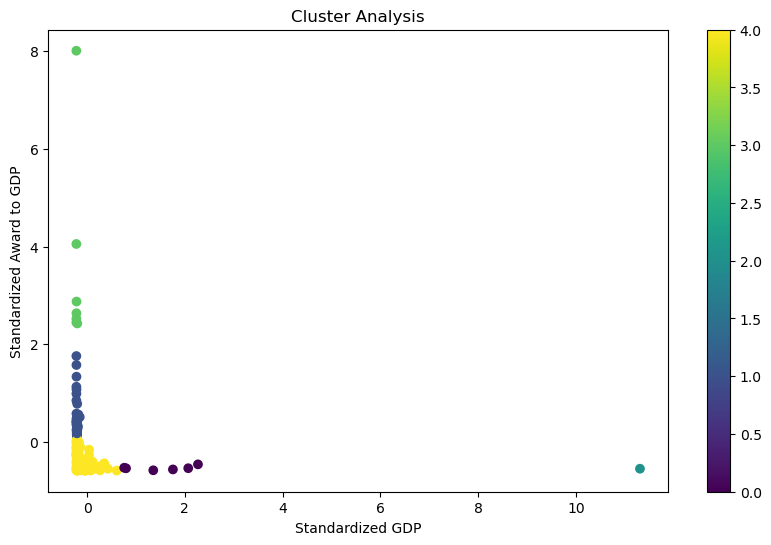

In [35]:
# run cluster analysis on the standardized GDP and Award to GDP
from sklearn.cluster import KMeans

X = df_grouped[["Standardized GDP", "Standardized Award to GDP"]]
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
df_grouped["Cluster"] = kmeans.labels_

# ignore the outliers
# df_grouped = df_grouped[df_grouped["Standardized Award to GDP"] > -3][df_grouped["Standardized Award to GDP"] < 3]
# df_grouped = df_grouped[df_grouped["Standardized GDP"] > -3][ df_grouped["Standardized GDP"] < 3]

# plot the clusters and specify cluster numbers
plt.figure(figsize=(10, 6))
plt.scatter(df_grouped["Standardized GDP"], df_grouped["Standardized Award to GDP"], c=df_grouped["Cluster"], cmap='viridis')
plt.xlabel("Standardized GDP")
plt.ylabel("Standardized Award to GDP")
plt.title("Cluster Analysis")
plt.colorbar()
plt.show()

In [36]:
# download the csv file from Github
# https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv
url = 'https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv'
df_regions = pd.read_csv(url)

# add the region to the main dataframe for each country code
df_grouped = df_grouped.merge(df_regions[['alpha-3', 'region']], left_on='Country Code', right_on='alpha-3', how='left')

# use pycountry and create a column for "Country Name"
df_grouped["Country Name"] = df_grouped["Country Code"].apply(lambda x: pycountry.countries.get(alpha_3=x).name)

# drop the "alpha-3" column
df_grouped.drop(columns=['alpha-3'], inplace=True)

In [37]:
df_grouped.head()

,Country Code,GDP,Award to GDP,Standardized GDP,Standardized Award to GDP,Cluster,region,Country Name
0,AFG,1.401559e+10,0.023937,-0.200910,2.425800,3,Asia,Afghanistan
1,AGO,7.091295e+10,0.000760,-0.120821,-0.493400,4,Africa,Angola
2,ALB,1.161795e+10,0.004426,-0.204285,-0.031564,4,Europe,Albania
3,ARG,4.056090e+11,0.001207,0.350297,-0.437028,4,Americas,Argentina
4,ARM,9.507756e+09,0.005437,-0.207255,0.095742,1,Asia,Armenia


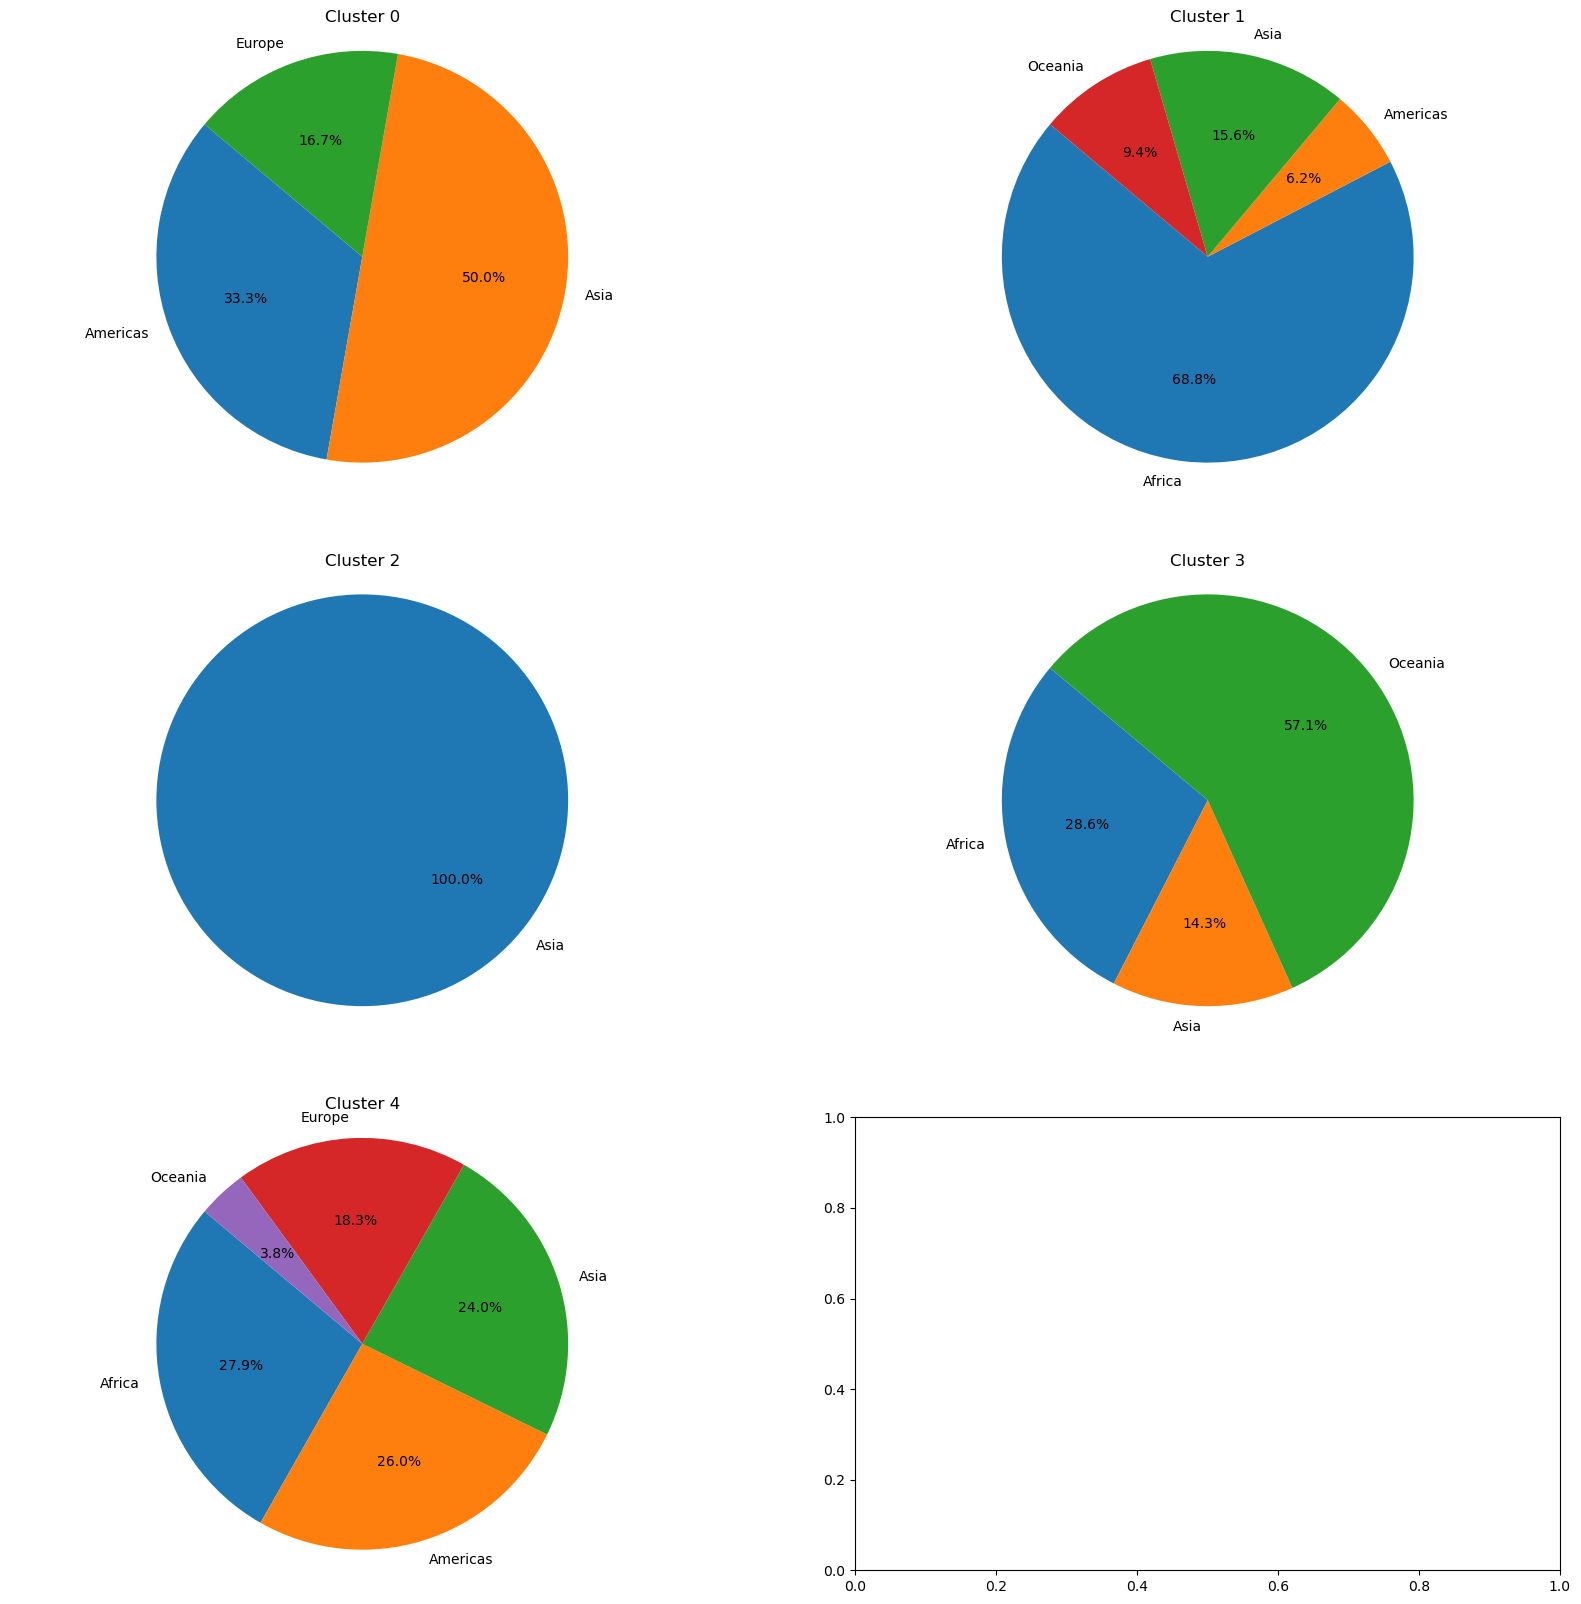

In [41]:
# describe the clusters for each region with plotting a pie chart for each cluster
# in subplots
fig, axes = plt.subplots(3, 2, figsize=(20, 20))
axes = axes.flatten()
for i in range(5):
    df_temp = df_grouped[df_grouped["Cluster"] == i]
    df_temp = df_temp.groupby("region").size().reset_index(name='Count')
    axes[i].pie(df_temp["Count"], labels=df_temp["region"], autopct='%1.1f%%', startangle=140)
    axes[i].axis('equal')
    axes[i].set_title(f"Cluster {i}")
plt.show()

In [42]:
# create a dictionary of the clusters and the countries in each cluster
cluster_dict = {}
for cluster in df_grouped["Cluster"].unique():
    cluster_dict[cluster] = df_grouped[df_grouped["Cluster"] == cluster]["Country Code"].values

def change_dict_keys(d, old_key, new_key):
    d[new_key] = d.pop(old_key)
    
change_dict_keys(cluster_dict, 0, "Middle GDP, Low Award")
change_dict_keys(cluster_dict, 1, "Low GDP, Middle Award")
change_dict_keys(cluster_dict, 2, "High GDP, Low Award")
change_dict_keys(cluster_dict, 3, "Low GDP, High Award")
change_dict_keys(cluster_dict, 4, "Low GDP, Low Award")

In [43]:
cluster_dict

{'Middle GDP, Low Award': array(['BRA', 'IDN', 'IND', 'MEX', 'RUS', 'TUR'], dtype=object),
 'Low GDP, Middle Award': array(['ARM', 'BDI', 'BFA', 'CAF', 'COD', 'CPV', 'DJI', 'DMA', 'ETH',
        'GEO', 'GMB', 'GNB', 'KGZ', 'LSO', 'MDG', 'MLI', 'MOZ', 'MWI',
        'NER', 'NIC', 'RWA', 'SEN', 'SLE', 'SOM', 'STP', 'TCD', 'TJK',
        'TLS', 'TON', 'UGA', 'VUT', 'WSM'], dtype=object),
 'High GDP, Low Award': array(['CHN'], dtype=object),
 'Low GDP, High Award': array(['AFG', 'ERI', 'FSM', 'KIR', 'LBR', 'MHL', 'TUV'], dtype=object),
 'Low GDP, Low Award': array(['AGO', 'ALB', 'ARG', 'ATG', 'AZE', 'BEN', 'BGD', 'BGR', 'BIH',
        'BLR', 'BLZ', 'BOL', 'BRB', 'BTN', 'BWA', 'CHL', 'CIV', 'CMR',
        'COG', 'COL', 'COM', 'CRI', 'CZE', 'DOM', 'DZA', 'ECU', 'EGY',
        'EST', 'FJI', 'GAB', 'GHA', 'GIN', 'GNQ', 'GRD', 'GTM', 'GUY',
        'HND', 'HRV', 'HTI', 'HUN', 'IRN', 'IRQ', 'JAM', 'JOR', 'KAZ',
        'KEN', 'KHM', 'KNA', 'KOR', 'LAO', 'LBN', 'LCA', 'LKA', 'LTU',
        'LVA',

##### Check for the Categories for Each Cluster

In [44]:
csv_new = "Contract_Awards_in_Investment_Project_Financing.csv"
csv_old = "Contract_Awards_in_Investment_Project_Financing__since_FY_2001_-_FY_2016_.csv"

url_new = "https://finances.worldbank.org/resource/kdui-wcs3.json"
url_old = "https://finances.worldbank.org/resource/4bhp-2q7b.json"

df_new = pd.read_csv(csv_new)
df_old = pd.read_csv(csv_old)

In [45]:
# make the region names consistent in both datasets by making them all lowercase except the first letters
df_new["Region"] = df_new["Region"].str.title()
df_old["Region"] = df_old["Region"].str.title()

# change the region names to match the new dataset
df_old["Region"] = df_old["Region"].replace("Africa East", "Eastern And Southern Africa")
df_old["Region"] = df_old["Region"].replace("Africa West", "Western And Central Africa")

# change the country names of "Eastern Africa" and "Western Africa" to match the new dataset
df_old.loc[df_old["Region"] == "Eastern And Southern Africa", "Borrower Country"] = df_old.loc[
    df_old["Region"] == "Eastern And Southern Africa", "Borrower Country"
    ].replace(
        "Eastern Africa", "Eastern And Southern Africa"
        )
df_old.loc[df_old["Region"] == "Western And Central Africa", "Borrower Country"] = df_old.loc[
    df_old["Region"] == "Western And Central Africa", "Borrower Country"
    ].replace(
        "Western Africa", "Western And Central Africa"
        ) 

# change "Turkey" to "Turkiye" in the old dataset
df_old.loc[df_old["Borrower Country"] == "Turkey", "Borrower Country"] = "Turkiye"

In [46]:
# merge the dataframes with the relevant categories as following:
# Fiscal Year, Region, Borrower Country, Project Global Practice, Supplier Contract Amount (USD)
df_new = df_new[['Fiscal Year',
                 'Region',
                 'Borrower Country',
                 'Project Global Practice',
                 'Supplier Contract Amount (USD)']]
df_old = df_old[['Fiscal Year',
                 'Region',
                 'Borrower Country',
                 'Project Global Practice',
                 'Supplier Contract Amount']]

# rename the columns to match the old dataframe
df_new.rename(columns={'Supplier Contract Amount (USD)': 'Supplier Contract Amount'}, inplace=True)

# merge the dataframes, removing any duplicates
df_2 = pd.concat([df_new, df_old], ignore_index=True)
df_2.drop_duplicates(inplace=True)

df_2.head()

,Fiscal Year,Region,Borrower Country,Project Global Practice,Supplier Contract Amount
0,2024,Latin America And Caribbean,Colombia,Information and Communications Technologies;Ag...,32123.28
1,2024,Eastern And Southern Africa,Eastern and Southern Africa,"Financial Sector;Agriculture, Fishing and Fore...",77214.66
2,2024,Eastern And Southern Africa,Angola,"Water, Sanitation and Waste Management;Agricul...",371600.00
3,2024,Eastern And Southern Africa,Eastern and Southern Africa,"Financial Sector;Agriculture, Fishing and Fore...",130020.64
4,2024,Latin America And Caribbean,Haiti,Transportation;Public Administration,15000.00


In [47]:
sum_before_preprocessing = df_2["Supplier Contract Amount"].sum()

# we first merge the data entries that has the same YEAR, COUNTRY and PROJECT GLOBAL PRACTICE for their award amounts
df_2 = df_2.groupby(["Fiscal Year", "Region", "Borrower Country", "Project Global Practice"])["Supplier Contract Amount"].sum().reset_index()

sum_after_grouping = df_2["Supplier Contract Amount"].sum()

# we then split the "Project Global Practice" column into a list of practices
df_2["Project Global Practice"] = df_2["Project Global Practice"].str.split(";")

# create a new column that contains the number of items in the list of Project Global Practice
df_2["Project Global Practice Count"] = df_2["Project Global Practice"].apply(len)

# explode the "Project Global Practice" column so that each row contains only one practice
df_2 = df_2.explode("Project Global Practice")

# calculate the average award amount per project global practice within the same project
df_2["Supplier Contract Amount"] = (df_2["Supplier Contract Amount"] / df_2["Project Global Practice Count"]).round(2)

# we AGAIN merge the data entries that has the same YEAR, COUNTRY and PROJECT GLOBAL PRACTICE for their award amounts
df_2 = df_2.groupby(["Fiscal Year", "Region", "Borrower Country", "Project Global Practice"])["Supplier Contract Amount"].sum().reset_index()

sum_after_preprocessing = df_2["Supplier Contract Amount"].sum()

In [48]:
# group the data by country and Project Global Practice
df_grouped_2 = df_2.groupby(['Borrower Country', 'Project Global Practice', 'Fiscal Year']).sum().reset_index()

# rename the columns
df_grouped_2.rename(columns={"Borrower Country": "Country", "Fiscal Year": "Year"}, inplace=True)

C:\Users\husme\AppData\Local\Temp\ipykernel_21136\2370249560.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_grouped_2 = df_2.groupby(['Borrower Country', 'Project Global Practice', 'Fiscal Year']).sum().reset_index()


In [49]:
df_grouped_2["Project Global Practice"].unique()

array(['Agriculture, Fishing and Forestry', 'Education',
       'Energy and Extractives', 'Financial Sector', 'Health',
       'Industry, Trade and Services',
       'Information and Communications Technologies',
       'Public Administration', 'Social Protection', 'Transportation',
       'Water, Sanitation and Waste Management', '(Historic)Environment',
       '(Historic)Economic Policy', '(Historic)Industry'], dtype=object)

In [50]:
df_grouped_2.head()

,Country,Project Global Practice,Year,Supplier Contract Amount
0,Afghanistan,"Agriculture, Fishing and Forestry",2003,12554177.00
1,Afghanistan,"Agriculture, Fishing and Forestry",2004,20406081.00
2,Afghanistan,"Agriculture, Fishing and Forestry",2005,543214.80
3,Afghanistan,"Agriculture, Fishing and Forestry",2006,1479401.27
4,Afghanistan,"Agriculture, Fishing and Forestry",2007,36264929.07


In [51]:
df_grouped_2[df_grouped_2["Country"] == "Turkiye"]

,Country,Project Global Practice,Year,Supplier Contract Amount
21229,Turkiye,"Agriculture, Fishing and Forestry",2001,1.220412e+07
21230,Turkiye,"Agriculture, Fishing and Forestry",2002,1.484827e+07
21231,Turkiye,"Agriculture, Fishing and Forestry",2003,1.989752e+06
21232,Turkiye,"Agriculture, Fishing and Forestry",2004,1.858887e+06
21233,Turkiye,"Agriculture, Fishing and Forestry",2006,7.062580e+05
...,...,...,...,...
21444,Turkiye,"Water, Sanitation and Waste Management",2020,2.051942e+07
21445,Turkiye,"Water, Sanitation and Waste Management",2021,1.654339e+07
21446,Turkiye,"Water, Sanitation and Waste Management",2022,1.259891e+07
21447,Turkiye,"Water, Sanitation and Waste Management",2023,1.128254e+08


In [52]:
# considering the "Country" column, create a new column of "Country Code"
df_grouped_2["Country Code"] = df_grouped_2["Country"].apply(lambda x: pycountry.countries.get(name=x).alpha_3 if pycountry.countries.get(name=x) else None)

# print the "Country" values correspond to a None "Country Code"
df_grouped_2[df_grouped_2["Country Code"].isnull()]["Country"].unique()

custom_country_mapping = {
    'Africa': None, 'Aral Sea': None, 'Bolivia': 'BOL', 'Central America': None, 'Central Asia': None,
    "Cote d'Ivoire": 'CIV', 'Eastern Africa': None, 'Egypt, Arab Republic of': 'EGY',
    'Gambia, The': 'GMB', 'Kosovo': None, 'Kyrgyz Republic': 'KGZ', 'Moldova': 'MDA',
    'OECS Countries': None, 'Red Sea and Gulf of Aden': None, 'Slovak Republic': 'SVK',
    'St. Kitts and Nevis': 'KNA', 'St. Lucia': 'LCA', 'Tanzania': 'TZA', 'Turkiye': 'TUR',
    'Venezuela, Republica Bolivariana de': 'VEN', 'Vietnam': 'VNM',
    'West Bank and Gaza': None, 'Western Africa': None, 'Western Balkans': None,
    'Yemen, Republic of': 'YEM', 'Congo, Democratic Republic of': 'COD',
    'Congo, Republic of': 'COG', 'Mekong': None, 'St. Vincent and the Grenadines': 'VCT',
    'Caribbean': None, 'Latin America': None, 'Southern Africa': None, 'Czech Republic': 'CZE',
    'Europe and Central Asia': None, 'East Asia and Pacific': None, 'Caucasus': None,
    'World': None, 'Andean Countries': None, 'Central Africa': None,
    'Middle East and North Africa': None, 'Pacific Islands': None, 'Asia': None,
    'South Asia': None, 'Eastern and Southern Africa': None, 'St Maarten': None,
    'Western and Central Africa': None, 'Multi-Regional': None, 'South East Asia': None
}

# update the "Country Code" column with the custom mapping
df_grouped_2["Country Code"] = df_grouped_2["Country"].apply(
    lambda x: custom_country_mapping[x] 
    if x in custom_country_mapping.keys()
    else (
        pycountry.countries.get(name=x).alpha_3 
        if pycountry.countries.get(name=x)
        else None
        )
    )

In [53]:
df_grouped_2.head()

,Country,Project Global Practice,Year,Supplier Contract Amount,Country Code
0,Afghanistan,"Agriculture, Fishing and Forestry",2003,12554177.00,AFG
1,Afghanistan,"Agriculture, Fishing and Forestry",2004,20406081.00,AFG
2,Afghanistan,"Agriculture, Fishing and Forestry",2005,543214.80,AFG
3,Afghanistan,"Agriculture, Fishing and Forestry",2006,1479401.27,AFG
4,Afghanistan,"Agriculture, Fishing and Forestry",2007,36264929.07,AFG


In [54]:
# group the data by country code and Project Global Practice
df_grouped_2 = df_grouped_2.groupby(['Country Code', 'Project Global Practice', 'Year']).sum().reset_index()
df_grouped_2.head()

C:\Users\husme\AppData\Local\Temp\ipykernel_21136\3667265371.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_grouped_2 = df_grouped_2.groupby(['Country Code', 'Project Global Practice', 'Year']).sum().reset_index()


,Country Code,Project Global Practice,Year,Supplier Contract Amount
0,AFG,"Agriculture, Fishing and Forestry",2003,12554177.00
1,AFG,"Agriculture, Fishing and Forestry",2004,20406081.00
2,AFG,"Agriculture, Fishing and Forestry",2005,543214.80
3,AFG,"Agriculture, Fishing and Forestry",2006,1479401.27
4,AFG,"Agriculture, Fishing and Forestry",2007,36264929.07


In [55]:
print(cluster_dict.keys())

dict_keys(['Middle GDP, Low Award', 'Low GDP, Middle Award', 'High GDP, Low Award', 'Low GDP, High Award', 'Low GDP, Low Award'])


In [56]:
df_cluster_mid_low = df_grouped_2[df_grouped_2["Country Code"].isin(cluster_dict["Middle GDP, Low Award"])]
df_cluster_low_mid = df_grouped_2[df_grouped_2["Country Code"].isin(cluster_dict["Low GDP, Middle Award"])]
df_cluster_high_low = df_grouped_2[df_grouped_2["Country Code"].isin(cluster_dict["High GDP, Low Award"])]
df_cluster_low_high = df_grouped_2[df_grouped_2["Country Code"].isin(cluster_dict["Low GDP, High Award"])]
df_cluster_low_low = df_grouped_2[df_grouped_2["Country Code"].isin(cluster_dict["Low GDP, Low Award"])]

In [57]:
# for each cluster, calculate the total award amount for each Project Global Practice
df_cluster_mid_low = df_cluster_mid_low.groupby(["Project Global Practice"]).sum().reset_index()
# drop the "Year" column
df_cluster_mid_low.drop(columns=["Year"], inplace=True)

df_cluster_low_mid = df_cluster_low_mid.groupby(["Project Global Practice"]).sum().reset_index()
df_cluster_low_mid.drop(columns=["Year"], inplace=True)

df_cluster_high_low = df_cluster_high_low.groupby(["Project Global Practice"]).sum().reset_index()
df_cluster_high_low.drop(columns=["Year"], inplace=True)

df_cluster_low_high = df_cluster_low_high.groupby(["Project Global Practice"]).sum().reset_index()
df_cluster_low_high.drop(columns=["Year"], inplace=True)

df_cluster_low_low = df_cluster_low_low.groupby(["Project Global Practice"]).sum().reset_index()
df_cluster_low_low.drop(columns=["Year"], inplace=True)

C:\Users\husme\AppData\Local\Temp\ipykernel_21136\3448972159.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_cluster_mid_low = df_cluster_mid_low.groupby(["Project Global Practice"]).sum().reset_index()
C:\Users\husme\AppData\Local\Temp\ipykernel_21136\3448972159.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_cluster_low_mid = df_cluster_low_mid.groupby(["Project Global Practice"]).sum().reset_index()
C:\Users\husme\AppData\Local\Temp\ipykernel_21136\3448972159.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will de

In [58]:
df_cluster_mid_low.head()

,Project Global Practice,Supplier Contract Amount
0,"Agriculture, Fishing and Forestry",4.039966e+09
1,Education,1.333354e+09
2,Energy and Extractives,1.030625e+10
3,Financial Sector,1.045122e+09
4,Health,3.655334e+09


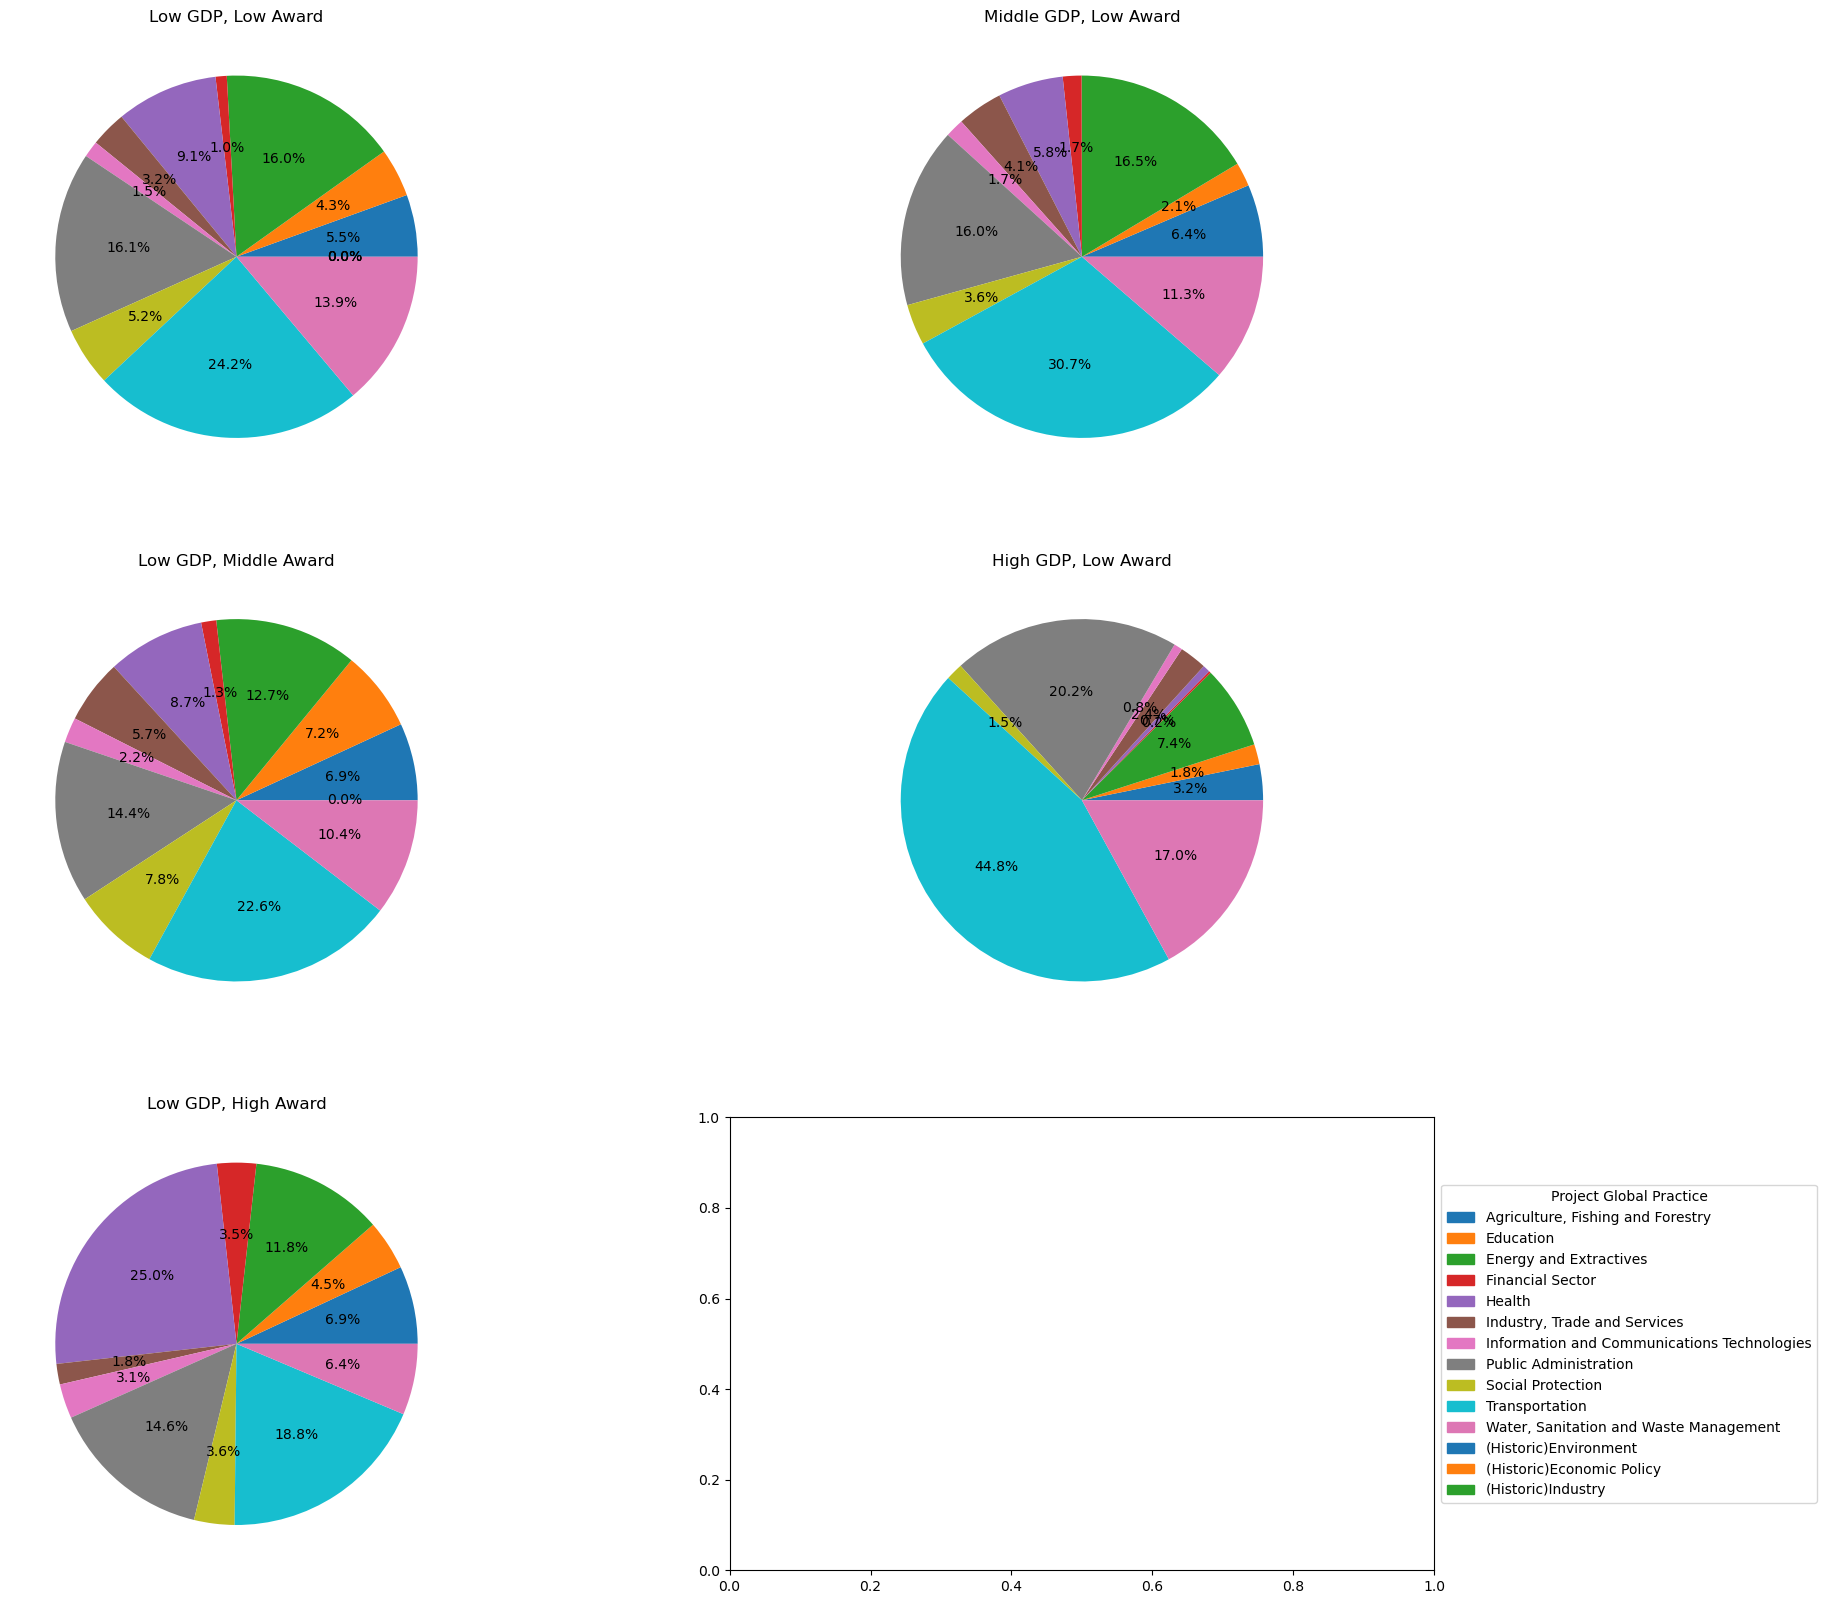

In [70]:
# pie chart the clusters with the same colors
# indicate in the legend the universal colors for each Project Global Practice
# do not write with text the names of the Project Global Practice in all the pie charts

import matplotlib.patches as mpatches

fig, axs = plt.subplots(3, 2, figsize=(20, 20))

color_scheme = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#dd77b4"]

# Step 1: Create a mapping of categories to colors
unique_categories = pd.concat([df_cluster_mid_low["Project Global Practice"],
                               df_cluster_low_mid["Project Global Practice"],
                               df_cluster_high_low["Project Global Practice"],
                               df_cluster_low_high["Project Global Practice"],
                               df_cluster_low_low["Project Global Practice"]]).unique()
category_color_map = {
    category: color_scheme[i % len(color_scheme)] for i, category in enumerate(unique_categories)
    }

# Step 2: Generate color lists for each pie chart
colors_mid_low = [category_color_map[category] for category in df_cluster_mid_low["Project Global Practice"]]
colors_low_mid = [category_color_map[category] for category in df_cluster_low_mid["Project Global Practice"]]
colors_high_low = [category_color_map[category] for category in df_cluster_high_low["Project Global Practice"]]
colors_low_high = [category_color_map[category] for category in df_cluster_low_high["Project Global Practice"]]
colors_low_low = [category_color_map[category] for category in df_cluster_low_low["Project Global Practice"]]

# Step 3: Use the generated color lists in the pie function
axs[0, 1].pie(df_cluster_mid_low["Supplier Contract Amount"],
              colors=colors_mid_low,
              autopct='%1.1f%%')
axs[1, 0].pie(df_cluster_low_mid["Supplier Contract Amount"],
              colors=colors_low_mid,
              autopct='%1.1f%%')
axs[1, 1].pie(df_cluster_high_low["Supplier Contract Amount"],
              colors=colors_high_low,
              autopct='%1.1f%%')
axs[2, 0].pie(df_cluster_low_high["Supplier Contract Amount"],
              colors=colors_low_high,
              autopct='%1.1f%%')
axs[0, 0].pie(df_cluster_low_low["Supplier Contract Amount"],
              colors=colors_low_low,
              autopct='%1.1f%%')

axs[0, 0].set_title("Low GDP, Low Award")
axs[1, 0].set_title("Low GDP, Middle Award")
axs[2, 0].set_title("Low GDP, High Award")
axs[0, 1].set_title("Middle GDP, Low Award")
axs[1, 1].set_title("High GDP, Low Award")

# Generate legend handles
legend_handles = [mpatches.Patch(color=color, label=category) for category, color in category_color_map.items()]
# Display the legend
plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5), title="Project Global Practice")

plt.show()

In [66]:
category_color_map

{'Agriculture, Fishing and Forestry': '#1f77b4',
 'Education': '#ff7f0e',
 'Energy and Extractives': '#2ca02c',
 'Financial Sector': '#d62728',
 'Health': '#9467bd',
 'Industry, Trade and Services': '#8c564b',
 'Information and Communications Technologies': '#e377c2',
 'Public Administration': '#7f7f7f',
 'Social Protection': '#bcbd22',
 'Transportation': '#17becf',
 'Water, Sanitation and Waste Management': '#dd77b4',
 '(Historic)Environment': '#1f77b4',
 '(Historic)Economic Policy': '#ff7f0e',
 '(Historic)Industry': '#2ca02c'}

{'Low GDP, Low Award': 1.0,
 'Low GDP, Middle Award': 1.0,
 'Low GDP, High Award': 1.0,
 'Middle GDP, Low Award': 1.0,
 'High GDP, Low Award': 1.0}